In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [48]:
df = pd.read_csv("data/creditcard.csv")
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Anonymized features that describe a transaction to predict a class

In [5]:
X = df.drop(columns=['Time', 'Amount', 'Class']).values
y = df['Class'].values
f"Shapes of X = {X.shape} y = {y.shape}. #Fraud Cases = {y.sum()}"

'Shapes of X = (284807, 28) y = (284807,). #Fraud Cases = 492'

492 fraud cases out of 284807 cases, unbalance dataset

In [8]:
from sklearn.linear_model import LogisticRegression

mod = LogisticRegression()
mod.fit(X, y).predict(X).sum()

np.int64(349)

The model detects fewer cases than the actual dataset. To detect more fraud cases we can weight the class

In [9]:
from sklearn.linear_model import LogisticRegression

mod = LogisticRegression(
    class_weight={0: 1, 1: 2}    # specify weight to each class, class 0 weight of 1, etc
)
mod.fit(X, y).predict(X).sum()

np.int64(434)

The model finds more fraud cases than without the weight class

In [10]:
from sklearn.model_selection import GridSearchCV

grid = GridSearchCV(
    estimator = LogisticRegression(),
    param_grid = {"class_weight": [{0: 1, 1: v} for v in range(1, 4)]},
    cv = 4,
    n_jobs = -1     # GridSearch can occur in parallel
)

grid.fit(X, y)

GridSearchCV(cv=4, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'class_weight': [{0: 1, 1: 1}, {0: 1, 1: 2},
                                          {0: 1, 1: 3}]})

In [13]:
pd.DataFrame(grid.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_class_weight,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
0,2.015388,0.408793,0.036275,0.016425,"{0: 1, 1: 1}","{'class_weight': {0: 1, 1: 1}}",0.999228,0.998890,0.999228,0.998919,0.999066,0.000162,3
1,1.758520,0.438848,0.034510,0.016101,"{0: 1, 1: 2}","{'class_weight': {0: 1, 1: 2}}",0.999270,0.999157,0.999171,0.999031,0.999157,0.000085,2
2,2.655302,0.273785,0.036272,0.029927,"{0: 1, 1: 3}","{'class_weight': {0: 1, 1: 3}}",0.999199,0.999256,0.999199,0.999115,0.999192,0.000050,1


How did GridSearchCV find the score cuz I didn't specify the metric?

In [15]:
lr = LogisticRegression()
??lr.score

Signature: lr.score(X, y, sample_weight=None)
Source:   
    def score(self, X, y, sample_weight=None):
        """
        Return the mean accuracy on the given test data and labels.

        In multi-label classification, this is the subset accuracy
        which is a harsh metric since you require for each sample that
        each label set be correctly predicted.

        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            Test samples.

        y : array-like of shape (n_samples,) or (n_samples, n_outputs)
            True labels for `X`.

        sample_weight : array-like of shape (n_samples,), default=None
            Sample weights.

        Returns
        -------
        score : float
            Mean accuracy of ``self.predict(X)`` w.r.t. `y`.
        """
        from .metrics import accuracy_score

        return accuracy_score(y, self.predict(X), sample_weight=sample_weight)
File:      c:\users\amirah\python_projects\scikit-le

If you wanna use a different metric as opposed to the model's default metric

In [18]:
from sklearn.metrics import precision_score, recall_score

display(precision_score(y, grid.predict(X)))    # given that i predict fraud, how accurate am I?
display(recall_score(y, grid.predict(X)))   # did i get all the fraud cases?

np.float64(0.8177874186550976)

np.float64(0.766260162601626)

Do we care more about false-positives (recall) or false-negatives (precision)?

Add precision and recall to the GridSearch

In [22]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score, recall_score, make_scorer

grid = GridSearchCV(
    estimator = LogisticRegression(),
    param_grid = {"class_weight": [{0: 1, 1: v} for v in range(1, 4)]},
    scoring = {'precision': make_scorer(precision_score), 'recall': make_scorer(recall_score)},
    refit = 'precision',    # mention to specifically select based on one of the scores
    return_train_score = True,
    cv = 4,
    n_jobs = -1     # GridSearch can occur in parallel
)

grid.fit(X, y)

GridSearchCV(cv=4, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'class_weight': [{0: 1, 1: 1}, {0: 1, 1: 2},
                                          {0: 1, 1: 3}]},
             refit='precision', return_train_score=True,
             scoring={'precision': make_scorer(precision_score, response_method='predict'),
                      'recall': make_scorer(recall_score, response_method='predict')})

You have to pass the metric functions to the make_scorer function first because

In [24]:
pd.DataFrame(grid.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_class_weight,params,split0_test_precision,split1_test_precision,split2_test_precision,split3_test_precision,...,split3_test_recall,mean_test_recall,std_test_recall,rank_test_recall,split0_train_recall,split1_train_recall,split2_train_recall,split3_train_recall,mean_train_recall,std_train_recall
0,1.976452,0.203794,0.164535,0.063297,"{0: 1, 1: 1}","{'class_weight': {0: 1, 1: 1}}",0.729730,0.940000,0.925000,0.870968,...,0.439024,0.575203,0.192511,3,0.753388,0.617886,0.588076,0.615176,0.643631,0.064431
1,2.112722,0.291338,0.106911,0.032512,"{0: 1, 1: 2}","{'class_weight': {0: 1, 1: 2}}",0.735099,0.956522,0.807692,0.800000,...,0.585366,0.676829,0.140509,2,0.766938,0.712737,0.699187,0.707317,0.721545,0.026648
2,1.814312,0.361363,0.115346,0.041700,"{0: 1, 1: 3}","{'class_weight': {0: 1, 1: 3}}",0.722973,0.960526,0.770492,0.800000,...,0.650407,0.719512,0.106392,1,0.780488,0.758808,0.756098,0.769648,0.766260,0.009653


Proper run: increase cross validation, increase class_weight iteration

In [25]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score, recall_score, make_scorer

grid = GridSearchCV(
    estimator = LogisticRegression(),
    param_grid = {"class_weight": [{0: 1, 1: v} for v in np.linspace(1, 20, 30)]},
    scoring = {'precision': make_scorer(precision_score), 'recall': make_scorer(recall_score)},
    refit = 'precision',    # mention to specifically select based on one of the scores
    return_train_score = True,
    cv = 10,        # increase cross validation
    n_jobs = -1     # GridSearch can occur in parallel
)

grid.fit(X, y)

GridSearchCV(cv=10, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'class_weight': [{0: 1, 1: np.float64(1.0)},
                                          {0: 1,
                                           1: np.float64(1.6551724137931034)},
                                          {0: 1,
                                           1: np.float64(2.310344827586207)},
                                          {0: 1,
                                           1: np.float64(2.9655172413793105)},
                                          {0: 1,
                                           1: np.float64(3.6206896551724137)},
                                          {0: 1,
                                           1: np.float64(4.275862068965517)},
                                          {0: 1,
                                           1: np.float64(4.931034482758621)},
                                          {0: 1,
                                           1:...
                                           1: np.float64(17.379310344827587)},
                                          {0: 1,
                                           1: np.float64(18.03448275862069)},
                                          {0: 1,
                                           1: np.float64(18.689655172413794)},
                                          {0: 1,
                                           1: np.float64(19.344827586206897)},
                                          {0: 1, 1: np.float64(20.0)}]},
             refit='precision', return_train_score=True,
             scoring={'precision': make_scorer(precision_score, response_method='predict'),
                      'recall': make_scorer(recall_score, response_method='predict')})

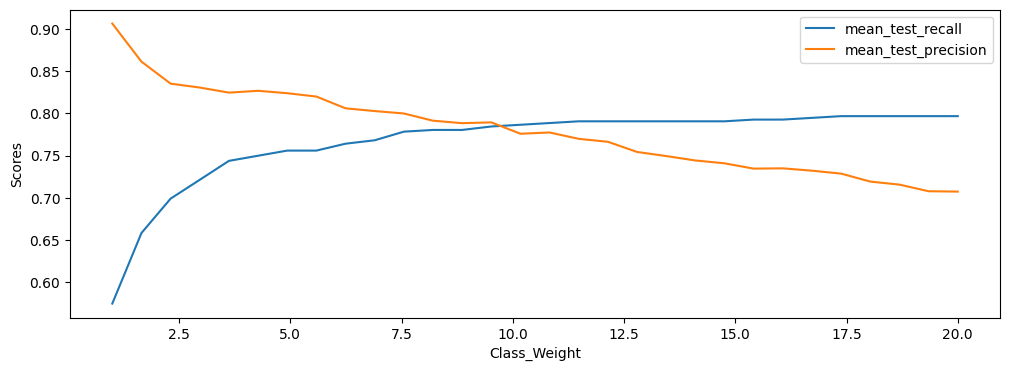

In [29]:
plt.figure(figsize=(12,4))
df = pd.DataFrame(grid.cv_results_)

for score in ['mean_test_recall', 'mean_test_precision']:
    plt.plot([_[1] for _ in df['param_class_weight']],
             df[score],
             label=score)
    
plt.xlabel('Class_Weight')
plt.ylabel('Scores')
plt.legend()

What do the scores from the train set tell us?

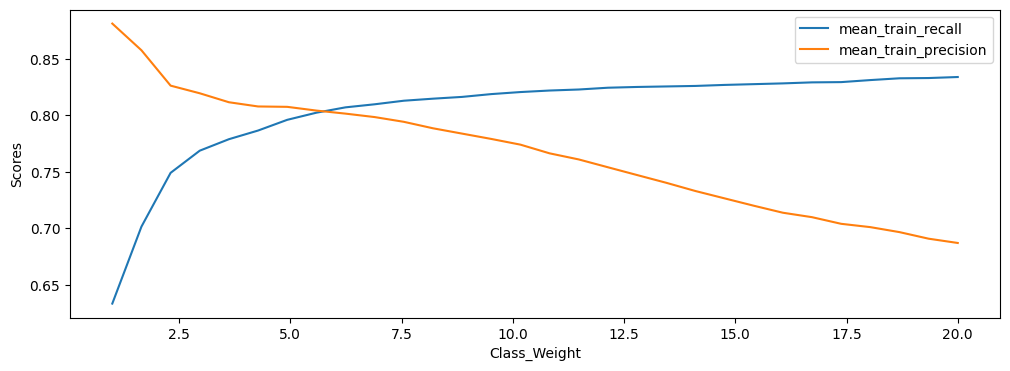

In [30]:
plt.figure(figsize=(12,4))
df = pd.DataFrame(grid.cv_results_)

for score in ['mean_train_recall', 'mean_train_precision']:
    plt.plot([_[1] for _ in df['param_class_weight']],
             df[score.replace('test','train')],
             label=score)
    
plt.xlabel('Class_Weight')
plt.ylabel('Scores')
plt.legend()

If you're looking for a balance of precision and recall, have a look at the F1 score.

In [31]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score, recall_score, make_scorer

# select min(recall, precision)
def min_recall_precision (y_true, y_pred):
    recall = recall_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    return min(recall, precision)

grid = GridSearchCV(
    estimator = LogisticRegression(),
    param_grid = {"class_weight": [{0: 1, 1: v} for v in np.linspace(1, 20, 30)]},
    scoring = {
        'precision': make_scorer(precision_score),
        'recall': make_scorer(recall_score),
        'min_both': make_scorer(min_recall_precision)
        },
    refit = 'min_both',    # mention to specifically select based on one of the scores
    return_train_score = True,
    cv = 10,        # increase cross validation
    n_jobs = -1     # GridSearch can occur in parallel
)

grid.fit(X, y)

GridSearchCV(cv=10, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'class_weight': [{0: 1, 1: np.float64(1.0)},
                                          {0: 1,
                                           1: np.float64(1.6551724137931034)},
                                          {0: 1,
                                           1: np.float64(2.310344827586207)},
                                          {0: 1,
                                           1: np.float64(2.9655172413793105)},
                                          {0: 1,
                                           1: np.float64(3.6206896551724137)},
                                          {0: 1,
                                           1: np.float64(4.275862068965517)},
                                          {0: 1,
                                           1: np.float64(4.931034482758621)},
                                          {0: 1,
                                           1:...
                                           1: np.float64(18.689655172413794)},
                                          {0: 1,
                                           1: np.float64(19.344827586206897)},
                                          {0: 1, 1: np.float64(20.0)}]},
             refit='min_both', return_train_score=True,
             scoring={'min_both': make_scorer(min_recall_precision, response_method='predict'),
                      'precision': make_scorer(precision_score, response_method='predict'),
                      'recall': make_scorer(recall_score, response_method='predict')})

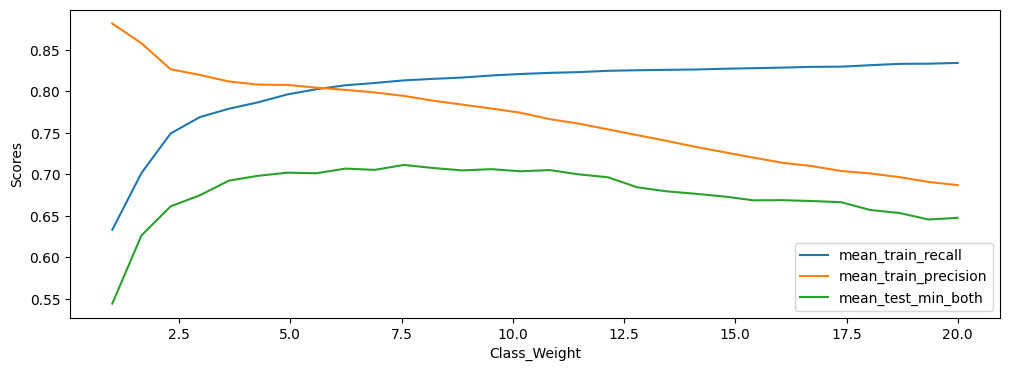

In [32]:
plt.figure(figsize=(12,4))
df = pd.DataFrame(grid.cv_results_)

for score in ['mean_train_recall', 'mean_train_precision', 'mean_test_min_both']:
    plt.plot([_[1] for _ in df['param_class_weight']],
             df[score],
             label=score)
    
plt.xlabel('Class_Weight')
plt.ylabel('Scores')
plt.legend()

Why is the mean_test_min_both lower than the recall and precision?
Because for each cross validation set you take the minimum of the recall or precision, then the mean for the entire set would be lower compared to the recall and precision set alone

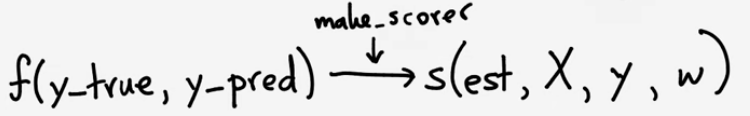
Coming back to the make_scorer

In [35]:
s = make_scorer(min_recall_precision)
??s

Signature:       s(estimator, X, y_true, sample_weight=None, **kwargs)
Type:            _Scorer
String form:     make_scorer(min_recall_precision, response_method='predict')
File:            c:\users\amirah\python_projects\scikit-learn\.venv\lib\site-packages\sklearn\metrics\_scorer.py
Source:         
class _Scorer(_BaseScorer):
    def _score(self, method_caller, estimator, X, y_true, **kwargs):
        """Evaluate the response method of `estimator` on `X` and `y_true`.

        Parameters
        ----------
        method_caller : callable
            Returns predictions given an estimator, method name, and other
            arguments, potentially caching results.

        estimator : object
            Trained estimator to use for scoring.

        X : {array-like, sparse matrix}
            Test data that will be fed to clf.decision_function or
            clf.predict_proba.

        y_true : array-like
            Gold standard target values for X. These must be class labels,
   

Write the min_recall_precision function so you no longer need make_scorer. Sample_weight allows to pass data that puts importance of rows i.e. transaction amount (domain knowledge)

In [37]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score, recall_score, make_scorer

# select min(recall, precision)
def min_recall_precision(est, X, y_true, sample_weight=None):
    y_pred = est.predict(X)
    recall = recall_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    return min(recall, precision)

grid = GridSearchCV(
    estimator = LogisticRegression(),
    param_grid = {"class_weight": [{0: 1, 1: v} for v in np.linspace(1, 20, 30)]},
    scoring = {
        'precision': make_scorer(precision_score),
        'recall': make_scorer(recall_score),
        'min_both': min_recall_precision       # can remove make_scorer
        },
    refit = 'min_both',    # mention to specifically select based on one of the scores
    return_train_score = True,
    cv = 10,        # increase cross validation
    n_jobs = -1     # GridSearch can occur in parallel
)

grid.fit(X, y)

GridSearchCV(cv=10, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'class_weight': [{0: 1, 1: np.float64(1.0)},
                                          {0: 1,
                                           1: np.float64(1.6551724137931034)},
                                          {0: 1,
                                           1: np.float64(2.310344827586207)},
                                          {0: 1,
                                           1: np.float64(2.9655172413793105)},
                                          {0: 1,
                                           1: np.float64(3.6206896551724137)},
                                          {0: 1,
                                           1: np.float64(4.275862068965517)},
                                          {0: 1,
                                           1: np.float64(4.931034482758621)},
                                          {0: 1,
                                           1:...
                                           1: np.float64(18.03448275862069)},
                                          {0: 1,
                                           1: np.float64(18.689655172413794)},
                                          {0: 1,
                                           1: np.float64(19.344827586206897)},
                                          {0: 1, 1: np.float64(20.0)}]},
             refit='min_both', return_train_score=True,
             scoring={'min_both': <function min_recall_precision at 0x000001D616064CC0>,
                      'precision': make_scorer(precision_score, response_method='predict'),
                      'recall': make_scorer(recall_score, response_method='predict')})

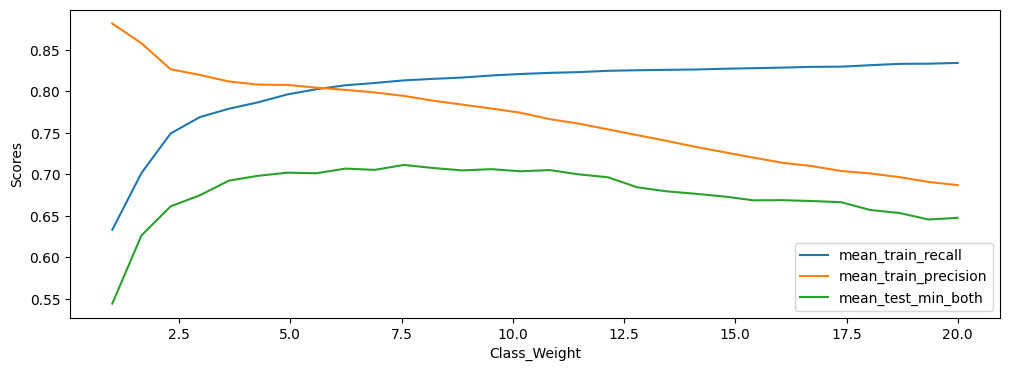

In [38]:
plt.figure(figsize=(12,4))
df = pd.DataFrame(grid.cv_results_)

for score in ['mean_train_recall', 'mean_train_precision', 'mean_test_min_both']:
    plt.plot([_[1] for _ in df['param_class_weight']],
             df[score],
             label=score)
    
plt.xlabel('Class_Weight')
plt.ylabel('Scores')
plt.legend()

What is the effect of the sample_weight to the output?

In [49]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score, recall_score, make_scorer

# select min(recall, precision)
def min_recall_precision(est, X, y_true, sample_weight=None):
    y_pred = est.predict(X)
    recall = recall_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    return min(recall, precision)

grid = GridSearchCV(
    estimator = LogisticRegression(),
    param_grid = {"class_weight": [{0: 1, 1: v} for v in np.linspace(1, 20, 30)]},
    scoring = {
        'precision': make_scorer(precision_score),
        'recall': make_scorer(recall_score),
        'min_both': min_recall_precision       # can remove make_scorer
        },
    refit = 'min_both',    # mention to specifically select based on one of the scores
    return_train_score = True,
    cv = 10,        # increase cross validation
    n_jobs = -1     # GridSearch can occur in parallel
)

grid.fit(X, y, sample_weight = np.log(1 + df['Amount']))    # balancing the amount weight with a log function

GridSearchCV(cv=10, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'class_weight': [{0: 1, 1: np.float64(1.0)},
                                          {0: 1,
                                           1: np.float64(1.6551724137931034)},
                                          {0: 1,
                                           1: np.float64(2.310344827586207)},
                                          {0: 1,
                                           1: np.float64(2.9655172413793105)},
                                          {0: 1,
                                           1: np.float64(3.6206896551724137)},
                                          {0: 1,
                                           1: np.float64(4.275862068965517)},
                                          {0: 1,
                                           1: np.float64(4.931034482758621)},
                                          {0: 1,
                                           1:...
                                           1: np.float64(18.03448275862069)},
                                          {0: 1,
                                           1: np.float64(18.689655172413794)},
                                          {0: 1,
                                           1: np.float64(19.344827586206897)},
                                          {0: 1, 1: np.float64(20.0)}]},
             refit='min_both', return_train_score=True,
             scoring={'min_both': <function min_recall_precision at 0x000001D6161916C0>,
                      'precision': make_scorer(precision_score, response_method='predict'),
                      'recall': make_scorer(recall_score, response_method='predict')})

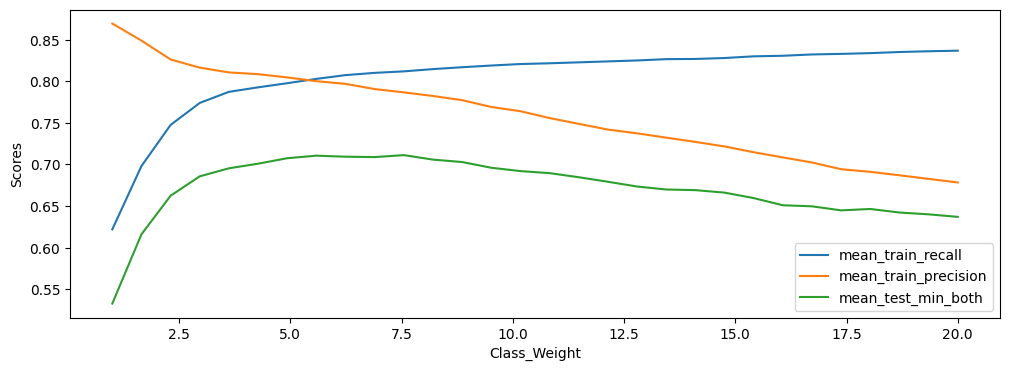

In [51]:
plt.figure(figsize=(12,4))
df_results = pd.DataFrame(grid.cv_results_)

for score in ['mean_train_recall', 'mean_train_precision', 'mean_test_min_both']:
    plt.plot([_[1] for _ in df_results['param_class_weight']],
             df_results[score],
             label=score)
    
plt.xlabel('Class_Weight')
plt.ylabel('Scores')
plt.legend()

What if fraud is like an outlier? What if we use an outlier detection algo?

In [53]:
from collections import Counter
from sklearn.ensemble import IsolationForest
mod = IsolationForest().fit(X)      #outlier detection model doesn't need a label, just a dataset
Counter(mod.predict(X))

Counter({np.int64(1): 274314, np.int64(-1): 10493})

In [54]:
np.where(mod.predict(X) == -1,1,0)

array([0, 0, 0, ..., 0, 0, 0])

In [63]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score, recall_score, make_scorer

def outlier_precision(mod, X, y):
    preds = mod.predict(X)
    return precision_score(y, np.where(preds == -1, 1, 0))  # change outlier to data source labels

def outlier_recall(mod, X, y):
    preds = mod.predict(X)
    return recall_score(y, np.where(preds == -1, 1,0))

grid = GridSearchCV(
    estimator = IsolationForest(),
    param_grid = {"contamination": np.linspace(0.001, 0.02, 10)},
    scoring = {
        'precision': outlier_precision,
        'recall': outlier_recall,
        },
    refit = 'precision',    # mention to specifically select based on one of the scores
    cv = 5,        # increase cross validation
    n_jobs = -1     # GridSearch can occur in parallel
)

grid.fit(X, y)    # balancing the amount weight with a log function

GridSearchCV(cv=5, estimator=IsolationForest(), n_jobs=-1,
             param_grid={'contamination': array([0.001     , 0.00311111, 0.00522222, 0.00733333, 0.00944444,
       0.01155556, 0.01366667, 0.01577778, 0.01788889, 0.02      ])},
             refit='precision',
             scoring={'precision': <function outlier_precision at 0x000001D61C22D620>,
                      'recall': <function outlier_recall at 0x000001D61C22CF40>})

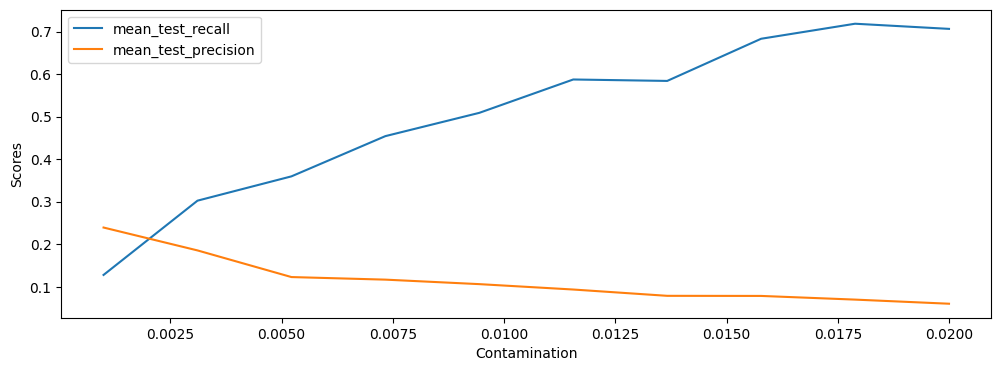

In [76]:
plt.figure(figsize=(12,4))
df_results = pd.DataFrame(grid.cv_results_)

for score in ['mean_test_recall', 'mean_test_precision']:
    plt.plot(df_results['param_contamination'],
            df_results[score],
             label=score)
    
plt.xlabel('Contamination')
plt.ylabel('Scores')
plt.legend()
